In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os 

import pandas as pd

import numpy as np

import pymc3 as pm
import arviz as az

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import pearsonr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from modules.data_handling import ExperimentParser, merge_sav_file
from modules.stats import build_logistic_model

In [20]:
# Aesthetics
def sns_styleset():
    """Configure parameters for plotting"""
    sns.set_theme(context='paper',
                  style='whitegrid',
                  palette='deep',
                  font='Arial')
    matplotlib.rcParams['figure.dpi']        = 150
    matplotlib.rcParams['axes.linewidth']    = 1
    matplotlib.rcParams['grid.color']        = '.8'
    matplotlib.rcParams['axes.edgecolor']    = '.15'
    matplotlib.rcParams['xtick.bottom']      = True
    matplotlib.rcParams['ytick.left']        = True
    matplotlib.rcParams['xtick.major.width'] = 1
    matplotlib.rcParams['ytick.major.width'] = 1
    matplotlib.rcParams['xtick.color']       = '.15'
    matplotlib.rcParams['ytick.color']       = '.15'
    matplotlib.rcParams['xtick.major.size']  = 3
    matplotlib.rcParams['ytick.major.size']  = 3
    matplotlib.rcParams['font.size']         = 10
    matplotlib.rcParams['axes.titlesize']    = 10
    matplotlib.rcParams['axes.labelsize']    = 10
    matplotlib.rcParams['legend.fontsize']   = 10
    matplotlib.rcParams['legend.frameon']    = False
    matplotlib.rcParams['xtick.labelsize']   = 8
    matplotlib.rcParams['ytick.labelsize']   = 8
sns_styleset()

MAPPING = {
    'disease': 'Disease',
    'weather': 'Weather',
    1: 'FnoA First',
    2: 'FnoA Second'
}

# Data Parsing

In [21]:
parser = ExperimentParser(
    experiment_dir='data//learning_task_40_s//'
)
parser.parse_dat_files()
parser.get_data()

  0%|                                                                                          | 0/147 [00:00<?, ?it/s]
                                                                                                                       
  0%|                                                                                          | 0/147 [00:00<?, ?it/s]
                                                                                                                       
  0%|                                                                                          | 0/147 [00:00<?, ?it/s]
                                                                                                                       
  0%|                                                                                          | 0/147 [00:00<?, ?it/s]
                                                                                                                       
  0%|                                   

                                                                                                                       
  0%|                                                                                          | 0/147 [00:00<?, ?it/s]
                                                                                                                       
  0%|                                                                                          | 0/147 [00:00<?, ?it/s]
                                                                                                                       
  0%|                                                                                          | 0/147 [00:00<?, ?it/s]
                                                                                                                       
  0%|                                                                                          | 0/147 [00:00<?, ?it/s]
                                        

,subno,fnoa_order,format,counterbal,condition,trial_n,phase,include,cue_1,cue_2,cue_3,cue_4,prob_outcome_1,outcome,resp_given,resp_norm_corr,resp_time,resp_rewar
0,s1,2,weather,1,AnoF,1.0,Training,1,1.0,0.0,0.0,0.0,0.75,2.0,None,1.0,None,None
1,s1,2,weather,1,AnoF,2.0,Training,1,0.0,0.0,1.0,1.0,0.00,2.0,None,2.0,None,None
2,s1,2,weather,1,AnoF,3.0,Training,1,1.0,0.0,0.0,0.0,0.75,1.0,None,1.0,None,None
3,s1,2,weather,1,AnoF,4.0,Training,1,0.0,0.0,1.0,0.0,0.25,1.0,None,2.0,None,None
4,s1,2,weather,1,AnoF,5.0,Training,1,0.0,0.0,1.0,0.0,0.25,2.0,None,2.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5425,s9,2,disease,1,FnoA,66.0,Test,1,1.0,0.0,1.0,1.0,0.25,NaN,2.0,2.0,1.007,None
5426,s9,2,disease,1,FnoA,67.0,Test,1,0.0,1.0,1.0,1.0,0.25,NaN,1.0,2.0,3.42,None
5427,s9,2,disease,1,FnoA,68.0,Test,1,1.0,0.0,0.0,0.0,0.75,NaN,1.0,1.0,1.09,None
5428,s9,2,disease,1,FnoA,69.0,Test,1,1.0,1.0,1.0,0.0,0.75,NaN,1.0,1.0,2.295,None


# Data Cleaning and Merging

In [22]:
fnoa_test = parser.get_data(filters={'condition': 'FnoA', 'phase': 'Test'})

# We first remove (i.e. discount) data when responsese as too fast
# As indicated by point a in the further information
# section of the assignment document
lower_limit = np.percentile(fnoa_test['resp_time'], 0.01)
fnoa_test = fnoa_test[fnoa_test['resp_time'] > lower_limit]
fnoa_test

,subno,fnoa_order,format,counterbal,condition,trial_n,phase,include,cue_1,cue_2,cue_3,cue_4,prob_outcome_1,outcome,resp_given,resp_norm_corr,resp_time,resp_rewar
122,s1,2,disease,1,FnoA,57.0,Test,1,1.0,1.0,0.0,0.0,1.00,NaN,2.0,1.0,1.05,None
123,s1,2,disease,1,FnoA,58.0,Test,1,0.0,1.0,0.0,0.0,0.75,NaN,2.0,1.0,1.035,None
124,s1,2,disease,1,FnoA,59.0,Test,1,1.0,0.0,1.0,0.0,0.50,NaN,1.0,NaN,0.876,None
125,s1,2,disease,1,FnoA,60.0,Test,1,0.0,0.0,1.0,0.0,0.25,NaN,2.0,2.0,1.383,None
126,s1,2,disease,1,FnoA,61.0,Test,1,0.0,0.0,0.0,1.0,0.25,NaN,1.0,2.0,0.695,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5425,s9,2,disease,1,FnoA,66.0,Test,1,1.0,0.0,1.0,1.0,0.25,NaN,2.0,2.0,1.007,None
5426,s9,2,disease,1,FnoA,67.0,Test,1,0.0,1.0,1.0,1.0,0.25,NaN,1.0,2.0,3.42,None
5427,s9,2,disease,1,FnoA,68.0,Test,1,1.0,0.0,0.0,0.0,0.75,NaN,1.0,1.0,1.09,None
5428,s9,2,disease,1,FnoA,69.0,Test,1,1.0,1.0,1.0,0.0,0.75,NaN,1.0,1.0,2.295,None


In [23]:
# we now derive the number of normatively correct responses
# the total number of normatively valid responses
# and the relative ratio
performance = fnoa_test[fnoa_test['resp_given'] == fnoa_test['resp_norm_corr']].groupby('subno').agg('size') 
performance = pd.DataFrame(performance, columns=['n_norm_corr']).reset_index()
performance['total_norm_corr'] = fnoa_test[~fnoa_test['resp_norm_corr'].isnull()].groupby('subno').agg('size').values
performance['ratio_norm_corr'] = performance['n_norm_corr'] / performance['total_norm_corr']

# get info from the experimental design
performance['format'] = fnoa_test.groupby('subno')['format'].unique().values
performance['format'] = performance['format'].apply(lambda x: MAPPING[x[0]])

performance['fnoa_order'] = fnoa_test.groupby('subno')['fnoa_order'].unique().values
performance['fnoa_order'] = performance['fnoa_order'].apply(lambda x: MAPPING[int(x[0])])

# we now merge with the personality data
performance = merge_sav_file(
    left_df=performance, 
    path='data//sav_files//learning_task_40_s.sav', 
    keys=['subno']
)

performance.head(10)

,subno,n_norm_corr,total_norm_corr,ratio_norm_corr,format,fnoa_order,age,ue,cd,ian,inc,epqe,epqp,bastot,nstot,harmtot
0,s1,4,9,0.444444,Disease,FnoA Second,25.0,6.0,16.0,13.0,14.0,6.0,7.0,35.0,26.0,27.0
1,s10,8,10,0.800000,Weather,FnoA First,23.0,22.0,18.0,5.0,20.0,19.0,11.0,42.0,27.0,18.0
2,s11,6,10,0.600000,Weather,FnoA Second,24.0,15.0,14.0,1.0,15.0,18.0,4.0,41.0,26.0,11.0
3,s12,4,10,0.400000,Disease,FnoA First,24.0,8.0,14.0,16.0,9.0,8.0,1.0,32.0,11.0,15.0
4,s13,6,10,0.600000,Disease,FnoA Second,21.0,12.0,8.0,6.0,14.0,14.0,8.0,49.0,20.0,5.0
5,s14,7,10,0.700000,Disease,FnoA Second,22.0,7.0,6.0,1.0,7.0,18.0,2.0,37.0,20.0,13.0
6,s15,4,10,0.400000,Weather,FnoA First,25.0,1.0,3.0,3.0,10.0,9.0,5.0,37.0,17.0,12.0
7,s16,3,10,0.300000,Weather,FnoA Second,24.0,11.0,8.0,15.0,14.0,17.0,10.0,29.0,9.0,24.0
8,s17,6,10,0.600000,Disease,FnoA First,25.0,1.0,6.0,5.0,8.0,11.0,4.0,37.0,16.0,11.0
9,s18,6,10,0.600000,Weather,FnoA First,25.0,8.0,3.0,0.0,11.0,18.0,3.0,34.0,23.0,11.0


In [24]:
# we save all the data locally for the sake of the assignment 
parser.get_data().to_csv('results//datasets//full_dataset.csv', index=False)
fnoa_test.to_csv('results//datasets//fnoa_test_dataset.csv', index=False)
performance.to_csv('results//datasets//perfromance_personality.csv', index=False)

# Data Analysis

### Descriptive Statistics

In [10]:
performance['n_norm_corr'].describe()

count    40.00000
mean      5.82500
std       1.72296
min       2.00000
25%       5.00000
50%       6.00000
75%       7.00000
max      10.00000
Name: n_norm_corr, dtype: float64

In [11]:
performance['ratio_norm_corr'].describe()

count    40.000000
mean      0.583611
std       0.171229
min       0.200000
25%       0.500000
50%       0.600000
75%       0.700000
max       1.000000
Name: ratio_norm_corr, dtype: float64

### Correlation Analysis

In [12]:
covariates = ['age', 'ue', 'cd', 'ian', 'inc', 'epqe', 'epqp', 'bastot', 'nstot', 'harmtot']
rhos = []
ps = []
for covariate in covariates:
    
    rho, p = pearsonr(performance['ratio_norm_corr'], performance[covariate])
    rhos.append(round(rho, 3))
    ps.append(round(p, 3))

corr_results = pd.DataFrame(np.array([covariates, rhos, ps]).T, columns=['Covariate', 'Spearman Rho', 'p-value'])
corr_results

,Covariate,Spearman Rho,p-value
0,age,-0.103,0.529
1,ue,0.178,0.271
2,cd,0.191,0.238
3,ian,-0.335,0.035
4,inc,0.146,0.367
5,epqe,0.269,0.093
6,epqp,-0.011,0.948
7,bastot,0.177,0.274
8,nstot,0.174,0.283
9,harmtot,0.134,0.41


### Experimental Design Analysis

<Figure size 750x750 with 0 Axes>

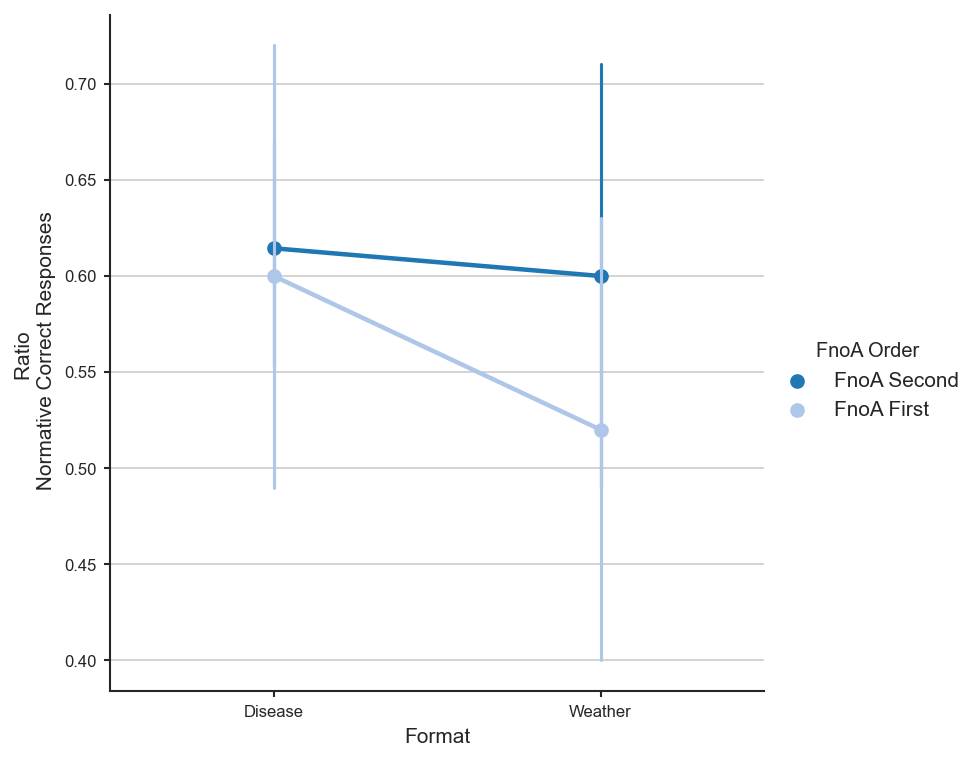

In [42]:
plt.figure(figsize=(5, 5))
figure = sns.catplot(
    x='format', 
    y='ratio_norm_corr', 
    hue='fnoa_order',
    kind='point', 
    data=performance,
    legend_out=True,
    linewidth=1,
    errwidth=1.5,
    palette='tab20'
)
figure._legend.set_title('FnoA Order')
plt.xlabel('Format')
plt.ylabel('Ratio \n Normative Correct Responses')
plt.savefig('results//figures//exper_design.png', dpi=500)

In [35]:
null_model = build_logistic_model(df=performance, null_model=True)
with null_model:
    
    null_trace = pm.sample(cores=1)

<ipython-input-35-aac7dd29d15e>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  null_trace = pm.sample(cores=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [36]:
logistic_model = build_logistic_model(df=performance, null_model=False)
with logistic_model:
    
    logistic_trace = pm.sample(cores=1)

<ipython-input-36-b51bc08cbf60>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  logistic_trace = pm.sample(cores=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Interaction Slope, Order Slope, Format Slope, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8786899719413437, but should be close to 0.8. Try to increase the number of tuning steps.


In [37]:
pm.summary(logistic_trace)

C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.072,0.197,-0.279,0.468,0.007,0.005,840.0,926.0,1.0
Format Slope,0.356,0.287,-0.158,0.921,0.010,0.007,844.0,1121.0,1.0
Order Slope,0.339,0.293,-0.212,0.873,0.010,0.007,865.0,1031.0,1.0
Interaction Slope,-0.290,0.412,-1.113,0.422,0.015,0.010,785.0,993.0,1.0


C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


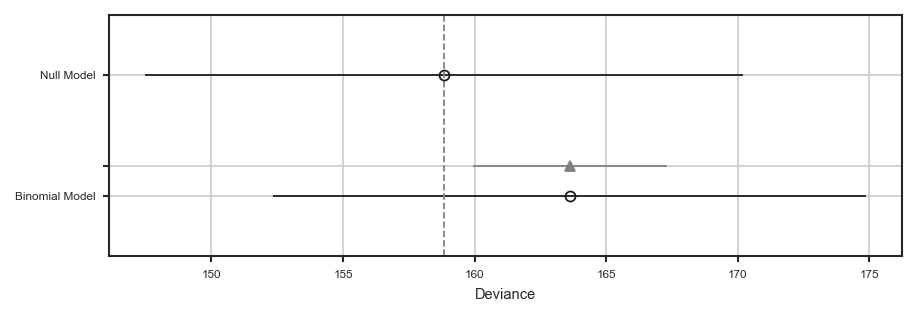

In [41]:
model_comp = az.compare(
    {
        "Null Model": null_trace, 
        "Binomial Model": logistic_trace
    },
    scale='deviance'
)
ax = az.plot_compare(model_comp, insample_dev=False)
plt.savefig('results//figures//model_comp_deviance.png', dpi=500)

### Frequentist Doouble Check

In [34]:
mod = smf.glm(
    "ratio_norm_corr ~ C(format, Treatment(reference='Weather')) * C(fnoa_order, Treatment(reference='FnoA First'))", 
    family=sm.families.Binomial(), 
    data=performance,
    var_weights=performance['total_norm_corr'].values
).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        ratio_norm_corr   No. Observations:                   40
Model:                            GLM   Df Residuals:                       36
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -186.87
Date:                Fri, 16 Apr 2021   Deviance:                       50.395
Time:                        16:28:55   Pearson chi2:                     44.7
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================================================
                                                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                0.0800      0.200      0.400      0.689      -0.312       0.472
C(format, Treatment(reference='Weather'))[T.Disease]                                                                     0.3254      0.286      1.138      0.255      -0.235       0.886
C(fnoa_order, Treatment(reference='FnoA First'))[T.FnoA Second]                                                          0.3254      0.286      1.138      0.255      -0.235       0.886
C(format, Treatment(reference='Weather'))[T.Disease]:C(fnoa_order, Treatment(reference='FnoA First'))[T.FnoA Second]    -0.2576      0.408     -0.632      0.527      -1.056       0.541
========================================================================================================================================================================================
"""